In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score, precision_recall_curve, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import roc_curve
from sklearn.metrics import auc





In [259]:
customers_final = pd.read_csv ('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement_final = pd.read_csv ('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing_final = pd.read_csv ('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions_final = pd.read_csv ('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [260]:
customers_final.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [261]:
customers_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [262]:
engagement_final.head()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
0,1,10,15,1
1,2,285,49,51
2,3,192,73,25
3,4,110,30,17
4,5,161,2,7


In [263]:
engagement_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [264]:
marketing_final.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [265]:
marketing_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [266]:
transactions_final.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


In [267]:
transactions_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


In [268]:
marketing_agg = marketing_final[marketing_final['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()

In [269]:
transactions_agg = transactions_final.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [270]:
customers_final.set_index('customer_id', inplace=True)
engagement_final.set_index('customer_id', inplace=True)

In [271]:
joint_data = customers_final.join(engagement_final).join(transactions_agg).join(marketing_agg)

In [272]:
# Feature Engineering
joint_data['number_of_site_visits'] = joint_data['number_of_site_visits'].fillna(0)
joint_data['number_of_emails_opened'] = joint_data['number_of_emails_opened'].fillna(0)
joint_data['number_of_clicks'] = joint_data['number_of_clicks'].fillna(0)

In [273]:
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.0,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.0,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.0,Male,New John,53,17,5,3,3503.13,1.0


In [274]:
num_rows = joint_data.shape[0]

### DATA CLEANING

#### Gender

In [275]:
joint_data.isnull().sum()

join_date                     0
last_purchase_date            0
age                        1009
gender                      533
location                      0
number_of_site_visits         0
number_of_emails_opened       0
number_of_clicks              0
transaction_id                0
transaction_amount            0
campaign_id                2335
dtype: int64

In [276]:
age_data = joint_data['age'].dropna()

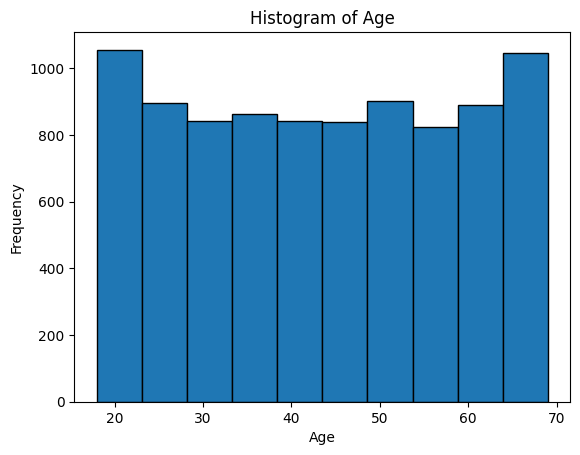

In [277]:
plt.hist(age_data, bins=10, edgecolor='k')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age')
plt.show()

In [278]:
skewness = age_data.skew()
kurtosis = age_data.kurt()

In [279]:
(f'Skewness: {skewness}')

'Skewness: -0.0007142573102785634'

In [280]:
(f'Kurtosis: {kurtosis}')

'Kurtosis: -1.2193730504932299'

In [281]:
# Calculate the mean of the 'age' column, excluding missing values
mean_age = joint_data['age'].mean()

# Fill missing values with the mean and assign back to the 'age' column
joint_data['age'] = joint_data['age'].fillna(mean_age)

#### Gender

In [282]:
gender_counts = joint_data['gender'].value_counts()

In [283]:
gender_counts

gender
Male      4769
Female    4698
Name: count, dtype: int64

In [284]:
# Fill missing values with the mean and assign back to the 'age' column
joint_data['age'] = joint_data['age'].fillna(mean_age)

# Calculate the mode of the 'gender' column, excluding missing values
mode_gender = joint_data['gender'].mode()[0]

# Fill missing values with the mode and assign back to the 'gender' column
joint_data['gender'] = joint_data['gender'].fillna(mode_gender)

# Display the DataFrame to check the changes
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,43.467467,Male,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.000000,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.000000,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.000000,Male,New John,53,17,5,3,3503.13,1.0


In [285]:
OneHotEncoder().fit_transform(joint_data[['gender']])

<10000x2 sparse matrix of type '<class 'numpy.float64'>'
	with 10000 stored elements in Compressed Sparse Row format>

In [286]:
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,43.467467,Male,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.000000,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.000000,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.000000,Male,New John,53,17,5,3,3503.13,1.0


#### Campaign ID

In [287]:
joint_data

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,43.467467,Male,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...
9996,2022-12-16,2023-08-13,42.000000,Female,Johnstonborough,119,47,16,10,5498.20,NaN
9997,2022-07-09,2023-01-25,26.000000,Male,Jessicamouth,3,33,14,12,5848.30,1.0
9998,2023-09-17,2024-01-30,39.000000,Male,New John,53,17,5,3,3503.13,1.0


In [288]:
joint_data['campaign_id'] = joint_data['campaign_id'].fillna(0)

### Feature Engineering

In [289]:
# Verify columns in joint_data
print(joint_data.columns)

Index(['join_date', 'last_purchase_date', 'age', 'gender', 'location',
       'number_of_site_visits', 'number_of_emails_opened', 'number_of_clicks',
       'transaction_id', 'transaction_amount', 'campaign_id'],
      dtype='object')


In [290]:
# Assuming `transactions_final` and `marketing_final` DataFrames are available

# Convert dates to datetime
transactions_final['transaction_date'] = pd.to_datetime(transactions_final['transaction_date'])

# Calculate Recency, Frequency, and Monetary for transactions
current_date = pd.to_datetime('2024-07-13')
recency = transactions_final.groupby('customer_id')['transaction_date'].max().reset_index()
recency['recency'] = (current_date - recency['transaction_date']).dt.days

frequency = transactions_final.groupby('customer_id').size().reset_index(name='frequency')

monetary = transactions_final.groupby('customer_id')['transaction_amount'].sum().reset_index(name='monetary')

# Merge RFM features
rfm = recency.merge(frequency, on='customer_id').merge(monetary, on='customer_id')

# Merge RFM features back into joint_data
joint_data = joint_data.merge(rfm, on='customer_id', how='left')

# Verify columns in marketing_final
print(marketing_final.columns)

# Create marketing features from marketing_final
marketing_features = marketing_final.groupby('customer_id').agg({
    'response': lambda x: (x == 'Yes').mean(),  # Calculate response rate
    'promotion_type': 'nunique'  # Number of unique promotions received
}).reset_index()

# Merge marketing features into joint_data
joint_data = joint_data.merge(marketing_features, on='customer_id', how='left')

# Handle any remaining missing values
joint_data.fillna(0, inplace=True)

# Display the feature-engineered DataFrame
joint_data.head()


Index(['campaign_id', 'customer_id', 'response', 'promotion_type',
       'campaign_date'],
      dtype='object')


,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,transaction_date,recency,frequency,monetary,response,promotion_type
0,1,2023-11-20,2024-03-17,56.000000,Female,North Shannonbury,10,15,1,6,3509.48,1.0,2024-03-12,123,6,3509.48,0.25,3
1,2,2021-09-08,2023-10-25,43.467467,Male,Hillville,285,49,51,9,6081.32,2.0,2023-02-26,503,9,6081.32,0.50,2
2,3,2021-06-01,2022-11-27,43.467467,Male,North Latoyatown,192,73,25,6,1454.87,1.0,2022-11-18,603,6,1454.87,0.50,1
3,4,2022-01-01,2022-09-01,29.000000,Male,Grossstad,110,30,17,20,7874.68,1.0,2022-08-31,682,20,7874.68,0.25,3
4,5,2022-01-24,2023-06-02,43.467467,Male,East Matthewfort,161,2,7,24,15524.55,0.0,2023-06-01,408,24,15524.55,0.00,3


In [291]:
# Group by 'customer_id' and calculate the average transaction amount
average_transaction_amount = transactions_final.groupby('customer_id')['transaction_amount'].mean().reset_index()

# Rename the column for clarity
average_transaction_amount.columns = ['customer_id', 'average_transaction_amount']

#### Calculate CLV

In [292]:
joint_data['tenure'] = (pd.to_datetime(joint_data['last_purchase_date']) - pd.to_datetime(joint_data['join_date'])).dt.days


In [293]:
# Calculate Average Purchase Value for each customer
joint_data['average_purchase_value'] = joint_data['monetary'] / joint_data['frequency']

# Calculate Average Purchase Frequency Rate (assuming you have tenure in months for a better rate calculation)
joint_data['average_purchase_frequency'] = joint_data['frequency'] / (joint_data['tenure'] / 30)

# Calculate Customer Value
joint_data['customer_value'] = joint_data['average_purchase_value'] * joint_data['average_purchase_frequency']

# Calculate Average Customer Lifespan (in months)
average_customer_lifespan = joint_data['tenure'].mean()/ 30  # Converting days to months

# Calculate CLV for Each Customer
joint_data['clv'] = joint_data['customer_value'] * average_customer_lifespan

# Display the DataFrame with CLV for each customer
joint_data[['customer_id', 'clv']]

,customer_id,clv
0,1,11967.136455
1,2,3149.244043
2,3,1076.105293
3,4,13039.355310
4,5,12645.079093
...,...,...
9995,9996,9218.043865
9996,9997,11766.007624
9997,9998,10441.237255
9998,9999,40980.287983


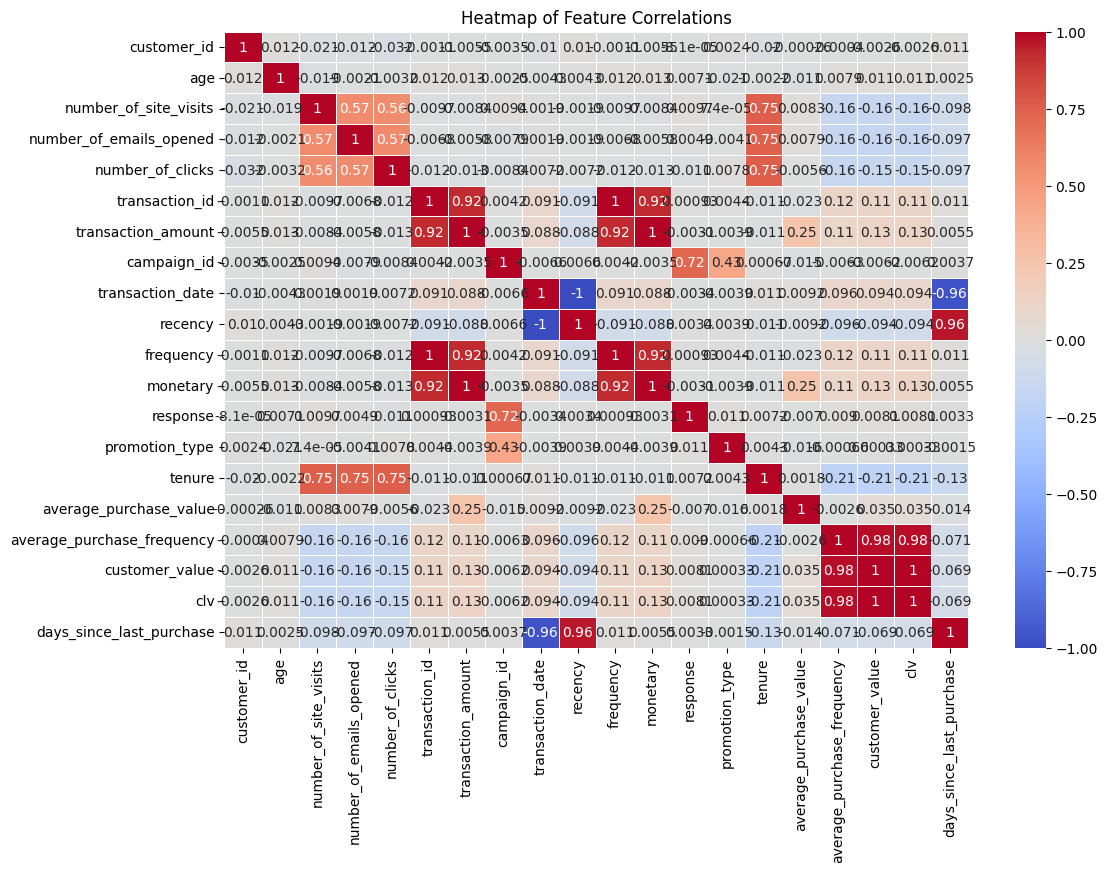

In [294]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Drop rows with missing values
joint_data.dropna(inplace=True)

# Convert date columns to numeric values (example for 'last_purchase_date')
if 'last_purchase_date' in joint_data.columns:
    reference_date = pd.to_datetime('2024-07-14')
    joint_data['days_since_last_purchase'] = (reference_date - pd.to_datetime(joint_data['last_purchase_date'])).dt.days
    joint_data.drop(columns=['last_purchase_date'], inplace=True)

# Convert any other non-numeric columns to numeric or drop them
for column in joint_data.columns:
    if joint_data[column].dtype == 'object':
        try:
            joint_data[column] = joint_data[column].astype(float)
        except ValueError:
            joint_data.drop(columns=[column], inplace=True)

# Calculate the correlation matrix
correlation_matrix = joint_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Feature Correlations')
plt.show()


In [295]:
# Convert CLV into binary classes (1 for high CLV, 0 for low CLV)
median_clv = joint_data['clv'].median()
joint_data['clv_class'] = (joint_data['clv'] > median_clv).astype(int)

### Check for Data Balance

In [296]:
joint_data.groupby('clv_class')['customer_id'].count()

clv_class
0    5000
1    5000
Name: customer_id, dtype: int64

### Model Selection

In [297]:
# Assuming 'transactions_final' is your transactions DataFrame
# Calculate the average transaction amount for each customer
avg_transaction_amount = transactions_final.groupby('customer_id')['transaction_amount'].mean().reset_index()
avg_transaction_amount.columns = ['customer_id', 'average_transaction_amount']

# Merge this data back into joint_data
joint_data = joint_data.merge(avg_transaction_amount, on='customer_id', how='left')

# Display the updated joint_data with the new average transaction amount column
print(joint_data.head())

   customer_id        age  number_of_site_visits  number_of_emails_opened  \
0            1  56.000000                     10                       15   
1            2  43.467467                    285                       49   
2            3  43.467467                    192                       73   
3            4  29.000000                    110                       30   
4            5  43.467467                    161                        2   

   number_of_clicks  transaction_id  transaction_amount  campaign_id  \
0                 1               6             3509.48          1.0   
1                51               9             6081.32          2.0   
2                25               6             1454.87          1.0   
3                17              20             7874.68          1.0   
4                 7              24            15524.55          0.0   

  transaction_date  recency  ...  response  promotion_type  tenure  \
0       2024-03-12      123  ...  

In [298]:
avg_transaction_amount

,customer_id,average_transaction_amount
0,1,584.913333
1,2,675.702222
2,3,242.478333
3,4,393.734000
4,5,646.856250
...,...,...
9995,9996,549.820000
9996,9997,487.358333
9997,9998,1167.710000
9998,9999,560.155000


In [299]:
joint_data

,customer_id,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,transaction_date,recency,...,response,promotion_type,tenure,average_purchase_value,average_purchase_frequency,customer_value,clv,days_since_last_purchase,clv_class,average_transaction_amount
0,1,56.000000,10,15,1,6,3509.48,1.0,2024-03-12,123,...,0.25,3,118,584.913333,1.525424,892.240678,11967.136455,119,1,584.913333
1,2,43.467467,285,49,51,9,6081.32,2.0,2023-02-26,503,...,0.50,2,777,675.702222,0.347490,234.800000,3149.244043,263,0,675.702222
2,3,43.467467,192,73,25,6,1454.87,1.0,2022-11-18,603,...,0.50,1,544,242.478333,0.330882,80.231801,1076.105293,595,0,242.478333
3,4,29.000000,110,30,17,20,7874.68,1.0,2022-08-31,682,...,0.25,3,243,393.734000,2.469136,972.182716,13039.355310,682,1,393.734000
4,5,43.467467,161,2,7,24,15524.55,0.0,2023-06-01,408,...,0.00,3,494,646.856250,1.457490,942.786437,12645.079093,408,1,646.856250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,42.000000,119,47,16,10,5498.20,0.0,2023-06-11,398,...,0.00,2,240,549.820000,1.250000,687.275000,9218.043865,336,1,549.820000
9996,9997,26.000000,3,33,14,12,5848.30,1.0,2022-12-08,583,...,1.00,1,200,487.358333,1.800000,877.245000,11766.007624,536,1,487.358333
9997,9998,39.000000,53,17,5,3,3503.13,1.0,2024-01-01,194,...,1.00,1,135,1167.710000,0.666667,778.473333,10441.237255,166,1,1167.710000
9998,9999,31.000000,23,5,4,12,6721.86,0.0,2022-07-14,730,...,0.00,2,66,560.155000,5.454545,3055.390909,40980.287983,730,1,560.155000


In [300]:
# Define the features (X) and the target (y)
X = joint_data[['number_of_clicks','age','customer_id', 'average_transaction_amount', 'tenure']]
y = joint_data['clv']


#### Linear

In [301]:
import numpy as np

# Check for infinite values
print(np.isinf(y).sum())

# Check for NaN values
print(np.isnan(y).sum())


48
0


In [302]:
# Replace infinite values with NaN, then drop NaNs
y.replace([np.inf, -np.inf], np.nan, inplace=True)
y.dropna(inplace=True)

# Do the same for X to ensure corresponding rows are removed
X = X.loc[y.index]


In [303]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Linear Regression model
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred_lr)
mse = mean_squared_error(y_test, y_pred_lr)
r2 = r2_score(y_test, y_pred_lr)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")


Mean Absolute Error: 75079.86977259043
Mean Squared Error: 47700374832.26587
R^2 Score: 0.036022447798831236


In [304]:
from sklearn.linear_model import LinearRegression
model_lr = LinearRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)


#### Logistic Regression

In [305]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Define the features (X) and the target (y)
X = joint_dataX = joint_data[['number_of_clicks','age','customer_id', 'average_transaction_amount', 'tenure']]
y = joint_data['clv_class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

# Make predictions
y_pred_lr = model_lr.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)
class_report = classification_report(y_test, y_pred_lr)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.8315
Confusion Matrix:
[[819 200]
 [137 844]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1019
           1       0.81      0.86      0.83       981

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



#### KNN

In [306]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the features (X) and the target (y)
X = joint_data[['number_of_clicks','age','customer_id', 'average_transaction_amount', 'tenure']]
y = joint_data['clv_class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the KNN regressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Make predictions
y_pred_knn = knn.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred_knn)
mse = mean_squared_error(y_test, y_pred_knn)
r2 = r2_score(y_test, y_pred_knn)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"R-Squared: {r2}")


Mean Absolute Error: 0.2017
Mean Squared Error: 0.11818000000000002
R-Squared: 0.5271092864524092


### Improved Models

#### Logistic Regression

Accuracy: 0.8305
Confusion Matrix:
[[819 206]
 [133 842]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1025
           1       0.80      0.86      0.83       975

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000

ROC AUC: 0.9149408380237649


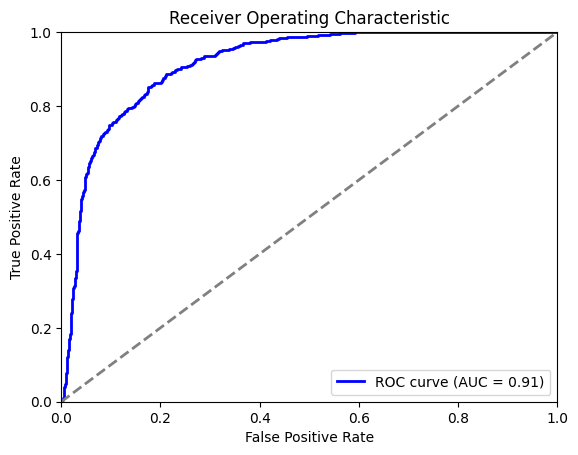

In [307]:
# Convert CLV into binary classes (1 for high CLV, 0 for low CLV)
median_clv = joint_data['clv'].median()
joint_data['clv_class'] = (joint_data['clv'] > median_clv).astype(int)

# Define the features (X) and the target (y)
X = joint_data[['number_of_clicks', 'age', 'average_transaction_amount', 'tenure']]
y = joint_data['clv_class']

# Polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True)
X_poly = poly.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initialize and train the Logistic Regression model with hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs'],
    'max_iter': [100, 200, 300]
}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid_search.fit(X_train, y_train)
model_lr = grid_search.best_estimator_

# Make predictions
y_pred_lr = model_lr.predict(X_test)
y_pred_prob = model_lr.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)
class_report = classification_report(y_test, y_pred_lr)
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)
print(f"ROC AUC: {roc_auc}")

# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


#### KNN

Best n_neighbors: 30
Accuracy: 0.851
ROC AUC: 0.9278614133833647


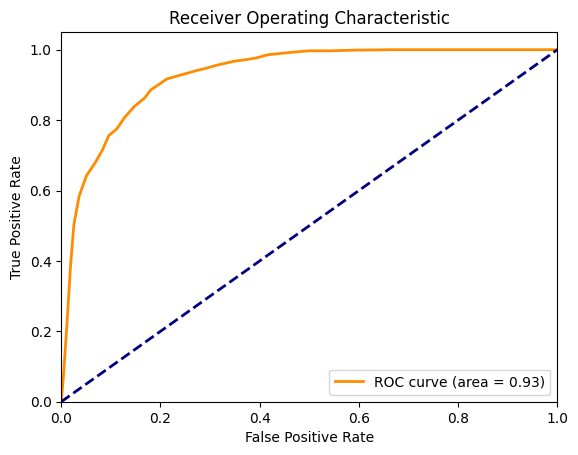

In [308]:
# Convert CLV into binary classes (1 for high CLV, 0 for low CLV)
median_clv = joint_data['clv'].median()
joint_data['clv_class'] = (joint_data['clv'] > median_clv).astype(int)

# Define the features (X) and the target (y)
X = joint_data[['number_of_clicks','age','customer_id', 'average_transaction_amount', 'tenure']]
y = joint_data['clv_class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the model and hyperparameters to tune
knn = KNeighborsClassifier()
param_grid = {'n_neighbors': range(1, 31)}

# Perform Grid Search
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best model
best_knn = grid_search.best_estimator_

# Make predictions
y_pred_knn = best_knn.predict(X_test)
y_pred_proba_knn = best_knn.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = best_knn.score(X_test, y_test)
roc_auc = roc_auc_score(y_test, y_pred_proba_knn)

print(f"Best n_neighbors: {grid_search.best_params_['n_neighbors']}")
print(f"Accuracy: {accuracy}")
print(f"ROC AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_knn)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
